# Analyse des données de Strokdem_AIRStroke

## Introduction

- Objectif du notebook
- Description des données

## Importation des bibliothèques

In [26]:
import os, sys, glob
import pydicom as dcm
import pandas as pd
import matplotlib.pyplot as plt #graphiques
from nipype.interfaces.dcm2nii import Dcm2niix
import numpy as np
#import matplotlib as plt
import nibabel as nb
from nibabel.freesurfer.mghformat import load
import nibabel.freesurfer as nifs
import seaborn as sns
%matplotlib inline
import pingouin as pg
from IPython.display import display,Image
pd.option_context('mode.use_inf_as_na', True)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scipy
from scipy.stats import linregress
import scipy.stats as stats
from scipy.stats import zscore

from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.tutorial.utils import fetch_mics_data
from brainstat.stats.terms import FixedEffect
import numpy as np
from brainstat.stats.SLM import SLM
from brainstat.datasets import fetch_parcellation
from nilearn.surface import surface
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainstat.context.meta_analysis import meta_analytic_decoder
from wordcloud import WordCloud


In [36]:
pial_left, pial_right = fetch_template_surface("fsaverage5",layer="pial",join=False)
inflated_left, inflated_right = fetch_template_surface("fsaverage5",layer="inflated",join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
mask = fetch_mask("fsaverage5")
glasser = fetch_parcellation("fsaverage5", "glasser", 360)

pial_left_fslr32k, pial_right_fslr32k = fetch_template_surface("fslr32k", join=False)
inflated_left_fslr32k,inflated_right_fslr32k = fetch_template_surface("fslr32k",layer="inflated", join=False)
vinflated_left_fslr32k,vinflated_right_fslr32k = fetch_template_surface("fslr32k",layer="vinflated", join=False)
pial_combined_fslr32k = fetch_template_surface("fslr32k", join=True)
mask_fslr32k = fetch_mask("fslr32k")
glasser_fslr32k = fetch_parcellation("fslr32k", "glasser", 360)

fs5_lh,fs5_rh = fetch_template_surface("fsaverage5", join=False,layer="inflated")
yeo_networks = fetch_parcellation("fsaverage5", "yeo", 7)

## Gestion des chemins 

In [4]:
STUDY_PATH="/NAS/tupac/protocoles/Strokdem/"
TS_PATH=os.path.join(STUDY_PATH,"TractSeg")
OUT_PATH=os.path.join(TS_PATH,"data","disconn")
CODE_DIR=os.path.join(TS_PATH,"code")
LOG_DIR=os.path.join(CODE_DIR,"log")
BIDS_DIR=os.path.join("/NAS","deathrow","renaud","dti_disconnection","bids_db")
BIDS_OUT_DIR=os.path.join("/NAS","deathrow","renaud","dti_disconnection","bids_db","derivatives2")
LD_DIR=os.path.join(STUDY_PATH,"Radiomique_SB_LoicDuron_2021","FreeSurfer_Output")
RL_DIR=os.path.join("/NAS","deathrow","renaud","dti_disconnection","bids_proc","freesurfer")
CB_DIR=os.path.join(STUDY_PATH,"FS5.1_T2mask")

## Chargement des données


Remarque(s)
les freesurfers sont dispatchés dans 3 repertoires :

    FS51_DIR="/NAS/tupac/protocoles/Strokdem/FS5.1_T2mask/"
    LD_DIR="/NAS/tupac/protocoles/Strokdem/Radiomique_SB_LoicDuron_2021/FreeSurfer_Output/"
    RL_DIR="/NAS/deathrow/renaud/dti_disconnection/bids_proc/freesurfer/"

In [33]:
FS_SUBJ_DIR=os.path.join(LD_DIR,SUBJ,f"{SUBJ}_{TIME}")
print(FS_SUBJ_DIR,f"{SUBJ}_M36")
FS_SUBJ_DIR=os.path.join(RL_DIR,f"{SUBJ}_{TIME}")
print(FS_SUBJ_DIR,f"{SUBJ}_M36")
FS_SUBJ_DIR=os.path.join(CB_DIR,f"{SUBJ}_{TIME}") 
print(FS_SUBJ_DIR,f"{SUBJ}_M36")

/NAS/tupac/protocoles/Strokdem/Radiomique_SB_LoicDuron_2021/FreeSurfer_Output/470924PV/470924PV_M36 470924PV_M36
/NAS/deathrow/renaud/dti_disconnection/bids_proc/freesurfer/470924PV_M36 470924PV_M36
/NAS/tupac/protocoles/Strokdem/FS5.1_T2mask/470924PV_M36 470924PV_M36


In [30]:
df_air_M6 = pd.read_excel(os.path.join(STUDY_PATH,"ListePtsAIRSTroke_M6.xlsx"),index_col=0,engine='openpyxl')
print(f"nb patients pour M6 = {len(list(df_air_M6.index.dropna()))}")
df_air_M36 = pd.read_excel(os.path.join(STUDY_PATH,"ListePtsAIRSTroke_M36.xlsx"),index_col=0,engine='openpyxl')
print(f"nb patients pour M36 = {len(list(df_air_M36.index.dropna()))}")
df_corr= pd.read_excel(os.path.join(STUDY_PATH,"Corresp_ID.xls"),index_col=0,engine='xlrd')

nb patients pour M6 = 163
nb patients pour M36 = 127


## Nettoyage des données 

Liste des manquants

In [31]:
TIME="M6"
TYPE="thickness"
SMT="5"
print("******************\nM6\n******************")
for SUBJ in df_corr.loc[list(df_air_M6.index.dropna())]['ID_IRM'].dropna() :
    TMP_F=os.path.join(TS_PATH,'CTsmoothed',SUBJ+'_'+TIME+"_rh."+TYPE+"."+SMT+".mgh")
    TMP_F_LD=os.path.join(LD_DIR,SUBJ)
    TMP_F_RL=os.path.join(RL_DIR,f"{SUBJ}_{TIME}")
    TMP_F_CB=os.path.join(CB_DIR,f"{SUBJ}_{TIME}")
    if not (os.path.exists(TMP_F) or os.path.exists(TMP_F_LD) or os.path.exists(TMP_F_RL) or os.path.exists(TMP_F_CB)) :
        print(f"NOK pour {SUBJ} : {TMP_F_LD}")

print("******************\nM36\n******************")
TIME="M36"
for SUBJ in df_corr.loc[list(df_air_M36.index.dropna())]['ID_IRM'].dropna() :
    TMP_F=os.path.join(TS_PATH,'CTsmoothed',SUBJ+'_'+TIME+"_rh."+TYPE+"."+SMT+".mgh")
    TMP_F_LD=os.path.join(LD_DIR,SUBJ)
    TMP_F_RL=os.path.join(RL_DIR,f"{SUBJ}_{TIME}")
    TMP_F_CB=os.path.join(CB_DIR,f"{SUBJ}_{TIME}")
    if not (os.path.exists(TMP_F) or os.path.exists(TMP_F_LD) or os.path.exists(TMP_F_RL) or os.path.exists(TMP_F_CB)) :
        print(f"NOK pour {SUBJ} : {TMP_F_LD}")

******************
M6
******************
NOK pour 640425SV : /NAS/tupac/protocoles/Strokdem/Radiomique_SB_LoicDuron_2021/FreeSurfer_Output/640425SV
NOK pour 360826MB : /NAS/tupac/protocoles/Strokdem/Radiomique_SB_LoicDuron_2021/FreeSurfer_Output/360826MB
NOK pour 350517BB : /NAS/tupac/protocoles/Strokdem/Radiomique_SB_LoicDuron_2021/FreeSurfer_Output/350517BB
NOK pour 371116SD : /NAS/tupac/protocoles/Strokdem/Radiomique_SB_LoicDuron_2021/FreeSurfer_Output/371116SD
NOK pour 320308BD : /NAS/tupac/protocoles/Strokdem/Radiomique_SB_LoicDuron_2021/FreeSurfer_Output/320308BD
NOK pour 380508FP : /NAS/tupac/protocoles/Strokdem/Radiomique_SB_LoicDuron_2021/FreeSurfer_Output/380508FP
NOK pour 480102CB : /NAS/tupac/protocoles/Strokdem/Radiomique_SB_LoicDuron_2021/FreeSurfer_Output/480102CB
******************
M36
******************
NOK pour 360826MB : /NAS/tupac/protocoles/Strokdem/Radiomique_SB_LoicDuron_2021/FreeSurfer_Output/360826MB
NOK pour 310501VH : /NAS/tupac/protocoles/Strokdem/Radiomique

Lancement des MICAPIPE Pour M6 et M36

In [91]:
TIME="M6"
TYPE="thickness"
SMT="5"
listJob=!qstat | grep romain | cut -d " " -f3
print(listJob)
print("******************\nM6\n******************")
for SUBJ in df_corr.loc[list(df_air_M6.index.dropna())]['ID_IRM'].dropna() :
    print(f"\033[1;32m {SUBJ}\033[0m")
    if not any([f"M1_{SUBJ}" in elt for elt in listJob]) :
        path_file_lh=os.path.join(BIDS_OUT_DIR,"micapipe_v0.2.0",f"sub-{SUBJ}","ses-2","maps",f"sub-{SUBJ}_ses-2_hemi-L_surf-fsaverage5_label-thickness.func.gii")
        if not os.path.exists(path_file_lh):
            BIDS_FILE=os.path.join(BIDS_DIR,f"sub-{SUBJ}","ses-2","anat",f"sub-{SUBJ}_ses-2_T1w.nii.gz")
            #TMP_F=os.path.join(TS_PATH,'CTsmoothed',SUBJ+'_'+TIME+"_rh."+TYPE+"."+SMT+".mgh")
            if os.path.exists(BIDS_FILE):
                FS_SUBJ_DIR=""
                if os.path.exists(os.path.join(LD_DIR,SUBJ,f"{SUBJ}_{TIME}")):                    
                    FS_SUBJ_DIR=os.path.join(LD_DIR,SUBJ,f"{SUBJ}_{TIME}")
                elif os.path.exists(os.path.join(RL_DIR,f"{SUBJ}_{TIME}")):
                    FS_SUBJ_DIR=os.path.join(RL_DIR,f"{SUBJ}_{TIME}")
                elif os.path.exists(os.path.join(CB_DIR,f"{SUBJ}_{TIME}")):
                    FS_SUBJ_DIR=os.path.join(CB_DIR,f"{SUBJ}_{TIME}")   
                else :
                    print(f"\033[0;31mNOK pour {SUBJ} : \033[0m")                
                
                if (len(FS_SUBJ_DIR)>0) :
                    #CMD_BASH=f"bash /NAS/deathrow/vincent/my_qbatch.sh -q two_job_q -oe {LOG_DIR} -N M6_{SUBJ} /home/global/micapipe/micapipe -force -sub sub-{SUBJ} -out {BIDS_OUT_DIR} -bids {BIDS_DIR} -ses 2 -fs_licence /home/global/freesurfer7.1/license.txt -proc_structural -proc_surf -post_structural -freesurfer -surf_dir {FS_SUBJ_DIR}"
                    CMD_BASH=f"bash /NAS/deathrow/vincent/my_qbatch.sh -q two_job_q -oe {LOG_DIR} -N M6_{SUBJ} /home/global/micapipe/micapipe -force -sub sub-{SUBJ} -out {BIDS_OUT_DIR} -bids {BIDS_DIR} -ses 2 -fs_licence /home/global/freesurfer7.1/license.txt -proc_structural -proc_surf -post_structural"
                    print(CMD_BASH)
                    #!$CMD_BASH
            else :
                print(f"\033[1;31m pas de BIDS pour {SUBJ} : {BIDS_FILE}\033[0m")    
        else :
            print(f"\033[1;32m OK {SUBJ} : {path_file_lh}\033[0m")
    else :
        print(f"\033[1;32m cmd in progress 4 {SUBJ} \033[0m")

[]
******************
M6
******************
 510702MFB
 OK 510702MFB : /NAS/deathrow/renaud/dti_disconnection/bids_db/derivatives2/micapipe_v0.2.0/sub-510702MFB/ses-2/maps/sub-510702MFB_ses-2_hemi-L_surf-fsaverage5_label-thickness.func.gii
 540724JLC
 OK 540724JLC : /NAS/deathrow/renaud/dti_disconnection/bids_db/derivatives2/micapipe_v0.2.0/sub-540724JLC/ses-2/maps/sub-540724JLC_ses-2_hemi-L_surf-fsaverage5_label-thickness.func.gii
 571216AT
 OK 571216AT : /NAS/deathrow/renaud/dti_disconnection/bids_db/derivatives2/micapipe_v0.2.0/sub-571216AT/ses-2/maps/sub-571216AT_ses-2_hemi-L_surf-fsaverage5_label-thickness.func.gii
 260410AV
 OK 260410AV : /NAS/deathrow/renaud/dti_disconnection/bids_db/derivatives2/micapipe_v0.2.0/sub-260410AV/ses-2/maps/sub-260410AV_ses-2_hemi-L_surf-fsaverage5_label-thickness.func.gii
 350605MM
 OK 350605MM : /NAS/deathrow/renaud/dti_disconnection/bids_db/derivatives2/micapipe_v0.2.0/sub-350605MM/ses-2/maps/sub-350605MM_ses-2_hemi-L_surf-fsaverage5_label-thickne

In [92]:
TIME="M36"
TYPE="thickness"
SMT="5"
listJob=!qstat | grep romain | cut -d " " -f3
print(listJob)
print("******************\nM36\n******************")
for SUBJ in df_corr.loc[list(df_air_M36.index.dropna())]['ID_IRM'].dropna() :#["391120GA"]:#
    print(f"\033[1;32m {SUBJ}\033[0m")
    if not any([f"M1_{SUBJ}" in elt for elt in listJob]) :
        path_file_lh=os.path.join(BIDS_OUT_DIR,"micapipe_v0.2.0",f"sub-{SUBJ}","ses-3","maps",f"sub-{SUBJ}_ses-3_hemi-L_surf-fsaverage5_label-thickness.func.gii")
        if not os.path.exists(path_file_lh):
            BIDS_FILE=os.path.join(BIDS_DIR,f"sub-{SUBJ}","ses-3","anat",f"sub-{SUBJ}_ses-3_T1w.nii.gz")
            #TMP_F=os.path.join(TS_PATH,'CTsmoothed',SUBJ+'_'+TIME+"_rh."+TYPE+"."+SMT+".mgh")
            if os.path.exists(BIDS_FILE):
                FS_SUBJ_DIR=""
                if os.path.exists(os.path.join(LD_DIR,SUBJ,f"{SUBJ}_{TIME}")):                    
                    FS_SUBJ_DIR=os.path.join(LD_DIR,SUBJ,f"{SUBJ}_{TIME}")
                elif os.path.exists(os.path.join(RL_DIR,f"sub-{SUBJ}",f"sub-{SUBJ}-ses-3")):
                    FS_SUBJ_DIR=os.path.join(RL_DIR,f"sub-{SUBJ}",f"sub-{SUBJ}-ses-3")
                elif os.path.exists(os.path.join(CB_DIR,f"{SUBJ}_{TIME}")):
                    FS_SUBJ_DIR=os.path.join(CB_DIR,f"{SUBJ}_{TIME}")   
                else :
                    print(f"\033[0;31mNOK pour {SUBJ} {TMP}: \033[0m")                
                
                if (len(FS_SUBJ_DIR)>0) :
                    #CMD_BASH=f"bash /NAS/deathrow/vincent/my_qbatch.sh -q two_job_q -oe {LOG_DIR} -N M36_{SUBJ} /home/global/micapipe/micapipe -force -sub sub-{SUBJ} -out {BIDS_OUT_DIR} -bids {BIDS_DIR} -ses 3 -fs_licence /home/global/freesurfer7.1/license.txt -proc_structural -proc_surf -post_structural -freesurfer -surf_dir {FS_SUBJ_DIR}"
                    CMD_BASH=f"bash /NAS/deathrow/vincent/my_qbatch.sh -q two_job_q -oe {LOG_DIR} -N M36_{SUBJ} /home/global/micapipe/micapipe -force -sub sub-{SUBJ} -out {BIDS_OUT_DIR} -bids {BIDS_DIR} -ses 3 -fs_licence /home/global/freesurfer7.1/license.txt -proc_structural -proc_surf -post_structural "
                    print(CMD_BASH)
                    #!$CMD_BASH
            else :
                print(f"\033[1;31m pas de BIDS pour {SUBJ} : {BIDS_FILE}\033[0m")    
        else :
            print(f"\033[1;32m OK {SUBJ} : {path_file_lh}\033[0m")
    else :
        print(f"\033[1;32m cmd in progress 4 {SUBJ} \033[0m")

[]
******************
M36
******************
 510702MFB
bash /NAS/deathrow/vincent/my_qbatch.sh -q two_job_q -oe /NAS/tupac/protocoles/Strokdem/TractSeg/code/log -N M36_510702MFB /home/global/micapipe/micapipe -force -sub sub-510702MFB -out /NAS/deathrow/renaud/dti_disconnection/bids_db/derivatives2 -bids /NAS/deathrow/renaud/dti_disconnection/bids_db -ses 3 -fs_licence /home/global/freesurfer7.1/license.txt -proc_structural -proc_surf -post_structural 
 571216AT
 OK 571216AT : /NAS/deathrow/renaud/dti_disconnection/bids_db/derivatives2/micapipe_v0.2.0/sub-571216AT/ses-3/maps/sub-571216AT_ses-3_hemi-L_surf-fsaverage5_label-thickness.func.gii
 260410AV
 OK 260410AV : /NAS/deathrow/renaud/dti_disconnection/bids_db/derivatives2/micapipe_v0.2.0/sub-260410AV/ses-3/maps/sub-260410AV_ses-3_hemi-L_surf-fsaverage5_label-thickness.func.gii
 350605MM
 OK 350605MM : /NAS/deathrow/renaud/dti_disconnection/bids_db/derivatives2/micapipe_v0.2.0/sub-350605MM/ses-3/maps/sub-350605MM_ses-3_hemi-L_surf-fs

In [39]:
# Convertir les colonnes 'ID_IRM' en ensembles
set1 = set(df_corr.loc[list(df_air_M6.index.dropna())]['ID_IRM'])
set2 = set(df_corr.loc[list(df_air_M36.index.dropna())]['ID_IRM'])

# Trouver les éléments communs
elements_communs = set1.intersection(set2)

# Afficher les éléments communs
print(f" patients commun au deux listes M6 et M36 : {len(elements_communs)}")

 patients commun au deux listes M6 et M36 : 116


liste des patients commun et non commun :

In [12]:
list0fPatients=[]

for SUBJ in elements_communs :
    path_file_lh_M36=os.path.join(BIDS_OUT_DIR,"micapipe_v0.2.0",f"sub-{SUBJ}","ses-3","maps",f"sub-{SUBJ}_ses-3_hemi-L_surf-fsaverage5_label-thickness.func.gii")
    path_file_lh_M6=os.path.join(BIDS_OUT_DIR,"micapipe_v0.2.0",f"sub-{SUBJ}","ses-2","maps",f"sub-{SUBJ}_ses-2_hemi-L_surf-fsaverage5_label-thickness.func.gii")
    if os.path.exists(path_file_lh_M6) and  os.path.exists(path_file_lh_M36) :
        print(f"\033[1;32m OK {SUBJ}\033[0m")
        list0fPatients.append(SUBJ)
    else :
        if os.path.exists(path_file_lh_M6) :
            print(f"\033[1;32m m6 OK {SUBJ}\033[0m \033[0;31m m36 NOK pour {SUBJ}\033[0m")
        else :
            print(f"\033[1;31m m6 NOK {SUBJ}\033[0m \033[0;32m m36 OK pour {SUBJ}\033[0m")

116
 OK 460711ML
 OK 680930WD
 OK 610415JD
 OK 381013FL
 OK 731001LC
 m6 OK 680518AH  m36 NOK pour 680518AH
 OK 670806JPP
 m6 OK 671019NL  m36 NOK pour 671019NL
 m6 OK 470327JPE  m36 NOK pour 470327JPE
 OK 571216AT
 OK 540412AB
 OK 350612JG
 OK 720501GL
 m6 OK 371011SG  m36 NOK pour 371011SG
 m6 OK 491228CD  m36 NOK pour 491228CD
 m6 OK 310501VH  m36 NOK pour 310501VH
 OK 450322MD
 OK 350112GC
 OK 391216FD
 OK 600506GH
 m6 OK 561020LA  m36 NOK pour 561020LA
 OK 420203JL
 m6 OK 620204BD  m36 NOK pour 620204BD
 m6 NOK 360826MB  m36 OK pour 360826MB
 OK 490301AC
 m6 OK 431119AM  m36 NOK pour 431119AM
 m6 NOK nan  m36 OK pour nan
 m6 OK 670213PC  m36 NOK pour 670213PC
 OK 420608JD
 m6 OK 380614FS  m36 NOK pour 380614FS
 OK 521029PB
 m6 OK 420919CB  m36 NOK pour 420919CB
 OK 360618RD
 m6 OK 490401AD  m36 NOK pour 490401AD
 OK 521008BT
 m6 OK 290318AB  m36 NOK pour 290318AB
 m6 OK 451229MTK  m36 NOK pour 451229MTK
 OK 370207MJD
 OK 600816JLS
 OK 450906AM
 OK 420220EM
 OK 390720GM
 m6 NOK 480

In [41]:
print(f"Nombre de patienst ayant une imagerie à M6 et M36 : {len(list0fPatients)}")

Nombre de patienst ayant une imagerie à M6 et M36 : 79


## chargement des épaisseurs corticales (lissées à 1, 6 et 11 mm) pour les patients communs 

In [18]:
#première dimension lignes les patients, deuxième dimension colonnes les régions, troisième dimension onglets lesvaleurs de smoothing 
#resultats = np.zeros((len(list0fPatients),361,6))
glasser360_aires_list = ["EXT","L_V1","L_MST","L_V6","L_V2","L_V3","L_V4","L_V8","L_4","L_3b","L_FEF","L_PEF","L_55b","L_V3A","L_RSC","L_POS2","L_V7","L_IPS1","L_FFC","L_V3B","L_LO1","L_LO2","L_PIT","L_MT","L_A1","L_PSL","L_SFL","L_PCV","L_STV","L_7Pm","L_7m","L_POS1","L_23d","L_v23ab","L_d23ab","L_31pv","L_5m","L_5mv","L_23c","L_5L","L_24dd","L_24dv","L_7AL","L_SCEF","L_6ma","L_7Am","L_7PL","L_7PC","L_LIPv","L_VIP","L_MIP","L_1","L_2","L_3a","L_6d","L_6mp","L_6v","L_p24pr","L_33pr","L_a24pr","L_p32pr","L_a24","L_d32","L_8BM","L_p32","L_10r","L_47m","L_8Av","L_8Ad","L_9m","L_8BL","L_9p","L_10d","L_8C","L_44","L_45","L_47l","L_a47r","L_6r","L_IFJa","L_IFJp","L_IFSp","L_IFSa","L_p9-46v","L_46","L_a9-46v","L_9-46d","L_9a","L_10v","L_a10p","L_10pp","L_11l","L_13l","L_OFC","L_47s","L_LIPd","L_6a","L_i6-8","L_s6-8","L_43","L_OP4","L_OP1","L_OP2-3","L_52","L_RI","L_PFcm","L_PoI2","L_TA2","L_FOP4","L_MI","L_Pir","L_AVI","L_AAIC","L_FOP1","L_FOP3","L_FOP2","L_PFt","L_AIP","L_EC","L_PreS","L_H","L_ProS","L_PeEc","L_STGa","L_PBelt","L_A5","L_PHA1","L_PHA3","L_STSda","L_STSdp","L_STSvp","L_TGd","L_TE1a","L_TE1p","L_TE2a","L_TF","L_TE2p","L_PHT","L_PH","L_TPOJ1","L_TPOJ2","L_TPOJ3","L_DVT","L_PGp","L_IP2","L_IP1","L_IP0","L_PFop","L_PF","L_PFm","L_PGi","L_PGs","L_V6A","L_VMV1","L_VMV3","L_PHA2","L_V4t","L_FST","L_V3CD","L_LO3","L_VMV2","L_31pd","L_31a","L_VVC","L_25","L_s32","L_pOFC","L_PoI1","L_Ig","L_FOP5","L_p10p","L_p47r","L_TGv","L_MBelt","L_LBelt","L_A4","L_STSva","L_TE1m","L_PI","L_a32pr","L_p24","R_V1","R_MST","R_V6","R_V2","R_V3","R_V4","R_V8","R_4","R_3b","R_FEF","R_PEF","R_55b","R_V3A","R_RSC","R_POS2","R_V7","R_IPS1","R_FFC","R_V3B","R_LO1","R_LO2","R_PIT","R_MT","R_A1","R_PSL","R_SFL","R_PCV","R_STV","R_7Pm","R_7m","R_POS1","R_23d","R_v23ab","R_d23ab","R_31pv","R_5m","R_5mv","R_23c","R_5L","R_24dd","R_24dv","R_7AL","R_SCEF","R_6ma","R_7Am","R_7PL","R_7PC","R_LIPv","R_VIP","R_MIP","R_1","R_2","R_3a","R_6d","R_6mp","R_6v","R_p24pr","R_33pr","R_a24pr","R_p32pr","R_a24","R_d32","R_8BM","R_p32","R_10r","R_47m","R_8Av","R_8Ad","R_9m","R_8BL","R_9p","R_10d","R_8C","R_44","R_45","R_47l","R_a47r","R_6r","R_IFJa","R_IFJp","R_IFSp","R_IFSa","R_p9-46v","R_46","R_a9-46v","R_9-46d","R_9a","R_10v","R_a10p","R_10pp","R_11l","R_13l","R_OFC","R_47s","R_LIPd","R_6a","R_i6-8","R_s6-8","R_43","R_OP4","R_OP1","R_OP2-3","R_52","R_RI","R_PFcm","R_PoI2","R_TA2","R_FOP4","R_MI","R_Pir","R_AVI","R_AAIC","R_FOP1","R_FOP3","R_FOP2","R_PFt","R_AIP","R_EC","R_PreS","R_H","R_ProS","R_PeEc","R_STGa","R_PBelt","R_A5","R_PHA1","R_PHA3","R_STSda","R_STSdp","R_STSvp","R_TGd","R_TE1a","R_TE1p","R_TE2a","R_TF","R_TE2p","R_PHT","R_PH","R_TPOJ1","R_TPOJ2","R_TPOJ3","R_DVT","R_PGp","R_IP2","R_IP1","R_IP0","R_PFop","R_PF","R_PFm","R_PGi","R_PGs","R_V6A","R_VMV1","R_VMV3","R_PHA2","R_V4t","R_FST","R_V3CD","R_LO3","R_VMV2","R_31pd","R_31a","R_VVC","R_25","R_s32","R_pOFC","R_PoI1","R_Ig","R_FOP5","R_p10p","R_p47r","R_TGv","R_MBelt","R_LBelt","R_A4","R_STSva","R_TE1m","R_PI","R_a32pr","R_p24"]
#glasser360_aires_list.insert(0, 'SUBJ')
valCT_M6 = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in [1,6,11]}
valCT_M36 = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in [1,6,11]}

for sm in [1,6,11]:
    nd_M36 = []
    nd_M6 = []
    for SUBJ in list0fPatients:
        path_file_lh_M36=os.path.join(BIDS_OUT_DIR,"micapipe_v0.2.0",f"sub-{SUBJ}","ses-3","maps",f"sub-{SUBJ}_ses-3_hemi-L_surf-fsaverage5_label-thickness_sm{sm}.func.gii")
        path_file_lh_M6=os.path.join(BIDS_OUT_DIR,"micapipe_v0.2.0",f"sub-{SUBJ}","ses-2","maps",f"sub-{SUBJ}_ses-2_hemi-L_surf-fsaverage5_label-thickness_sm{sm}.func.gii")
        path_file_rh_M36=os.path.join(BIDS_OUT_DIR,"micapipe_v0.2.0",f"sub-{SUBJ}","ses-3","maps",f"sub-{SUBJ}_ses-3_hemi-R_surf-fsaverage5_label-thickness_sm{sm}.func.gii")
        path_file_rh_M6=os.path.join(BIDS_OUT_DIR,"micapipe_v0.2.0",f"sub-{SUBJ}","ses-2","maps",f"sub-{SUBJ}_ses-2_hemi-R_surf-fsaverage5_label-thickness_sm{sm}.func.gii")

        tmp_rh_M36=nib.load(path_file_rh_M36)
        tmp_lh_M36=nib.load(path_file_lh_M36)
        tmp_rh_M6=nib.load(path_file_rh_M6)
        tmp_lh_M6=nib.load(path_file_lh_M6)
        
        volumeG1_M36 = np.concatenate([tmp_lh_M36.darrays[0].data,tmp_rh_M36.darrays[0].data], axis=0)
        volumeG1_M6 = np.concatenate([tmp_lh_M6.darrays[0].data,tmp_rh_M6.darrays[0].data], axis=0)
        valCT_M6[f"sm_{sm}"].append(volumeG1_M6)
        valCT_M36[f"sm_{sm}"].append(volumeG1_M36)
        nd_M36.append([np.median(volumeG1_M36[glasser==x])for x in np.unique(glasser)])
        nd_M6.append([np.median(volumeG1_M6[glasser==x])for x in np.unique(glasser)])

    df_M36 = pd.DataFrame(np.round(nd_M36,3), columns=glasser360_aires_list, index=list0fPatients)
    df_M6 = pd.DataFrame(np.round(nd_M6,3), columns=glasser360_aires_list, index=list0fPatients)
    df_M36 = df_M36.drop(columns=['EXT'])
    df_M6 = df_M6.drop(columns=['EXT'])
    df_M36 = df_M36.rename_axis("SUBJ")
    df_M6 = df_M6.rename_axis("SUBJ")
    df_M36.to_csv(os.path.join(STUDY_PATH,f"CTatM36_sm{sm}.csv"))
    df_M6.to_csv(os.path.join(STUDY_PATH,f"CTatM6_sm{sm}.csv"))

## Contrôle visuel

figure_title : /NAS/tupac/protocoles/Strokdem/screenshots/CTSurface_groupscomparison_M6_sm1.jpg


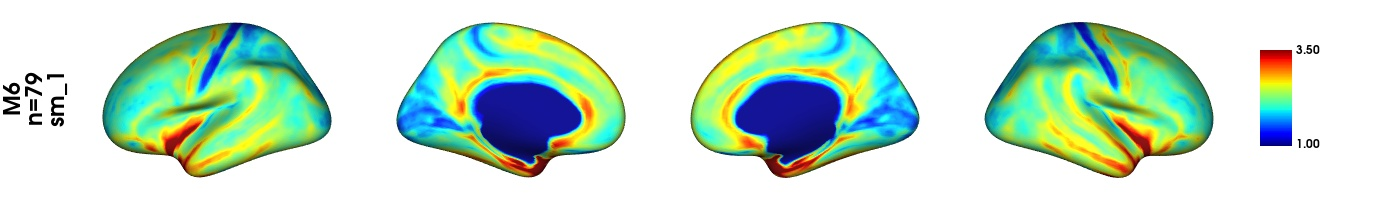

figure_title : /NAS/tupac/protocoles/Strokdem/screenshots/CTSurface_groupscomparison_M36_sm1.jpg


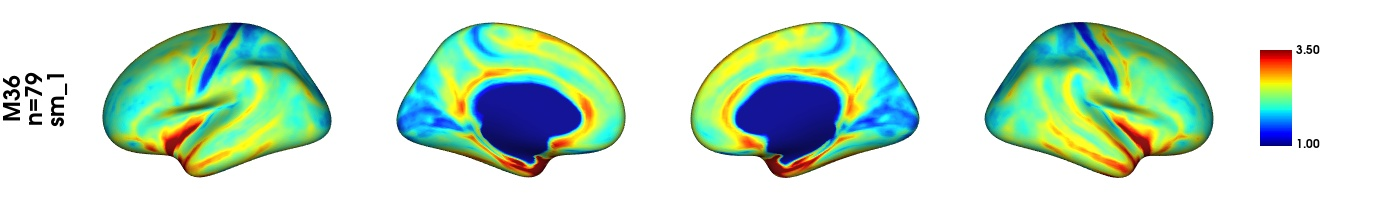

figure_title : /NAS/tupac/protocoles/Strokdem/screenshots/CTSurface_groupscomparison_M6_sm6.jpg


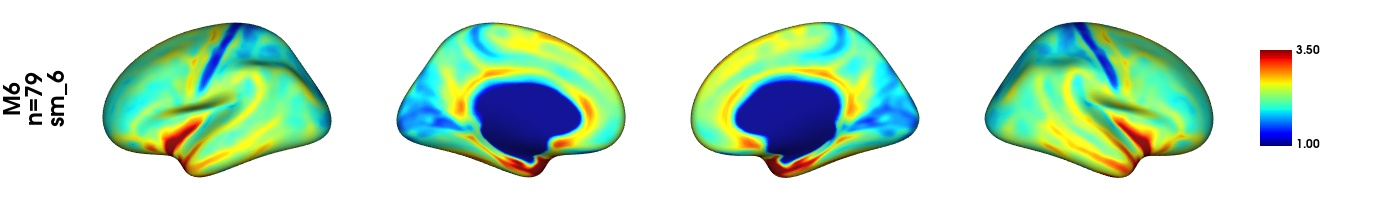

figure_title : /NAS/tupac/protocoles/Strokdem/screenshots/CTSurface_groupscomparison_M36_sm6.jpg


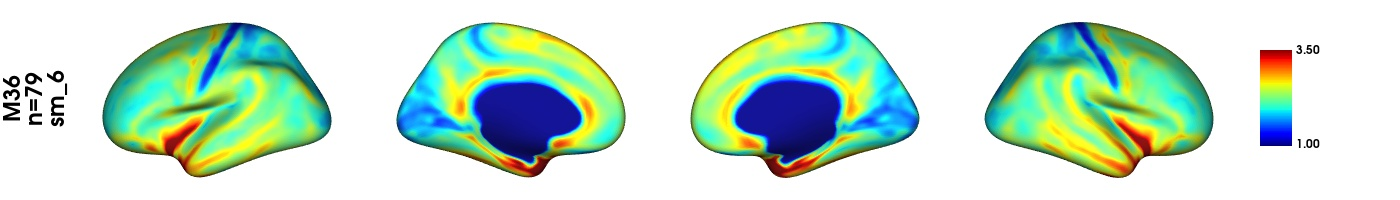

figure_title : /NAS/tupac/protocoles/Strokdem/screenshots/CTSurface_groupscomparison_M6_sm11.jpg


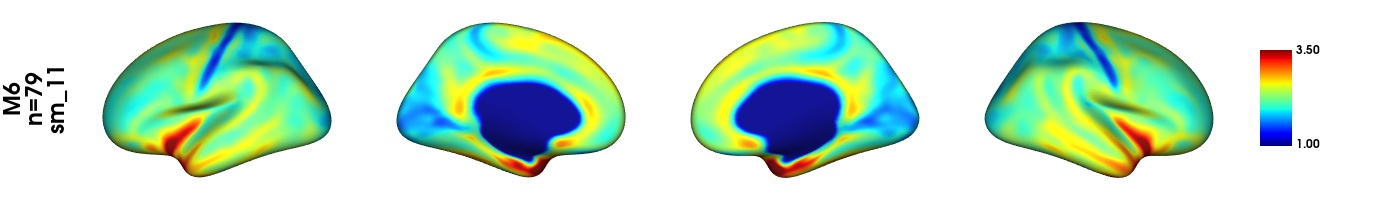

figure_title : /NAS/tupac/protocoles/Strokdem/screenshots/CTSurface_groupscomparison_M36_sm11.jpg


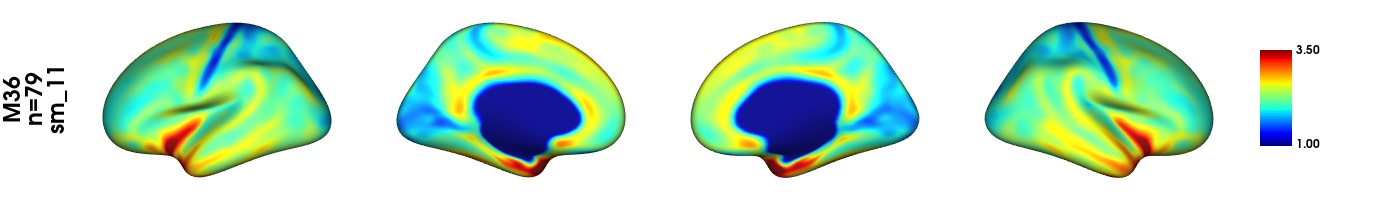

In [24]:
for smoothing_fwhm in [1,6,11]:
    figure_title=os.path.join(STUDY_PATH,"screenshots",f"CTSurface_groupscomparison_M6_sm{smoothing_fwhm}.jpg")
    df_CT = pd.DataFrame(np.array(valCT_M6[f"sm_{smoothing_fwhm}"]), index=list0fPatients)       
    plot_hemispheres(inflated_left, inflated_right,np.mean(df_CT,axis=0).values, color_bar=True, color_range=(1, 3.5),
        label_text=[f"M6\nn={len(df_CT)}\nsm_{smoothing_fwhm}"], cmap="jet", embed_nb=True, size=(1400, 200), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), transparent_bg=False,cb__labelTextProperty={"fontSize": 12}, interactive=True,screenshot=True, offscreen=False,filename=figure_title)
    print(f"figure_title : {figure_title}")                        
    display(Image(filename=figure_title))

    figure_title=os.path.join(STUDY_PATH,"screenshots",f"CTSurface_groupscomparison_M36_sm{smoothing_fwhm}.jpg")
    df_CT = pd.DataFrame(np.array(valCT_M6[f"sm_{smoothing_fwhm}"]), index=list0fPatients)       
    plot_hemispheres(inflated_left, inflated_right,np.mean(df_CT,axis=0).values, color_bar=True, color_range=(1, 3.5),
        label_text=[f"M36\nn={len(df_CT)}\nsm_{smoothing_fwhm}"], cmap="jet", embed_nb=True, size=(1400, 200), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), transparent_bg=False,cb__labelTextProperty={"fontSize": 12}, interactive=True,screenshot=True, offscreen=False,filename=figure_title)
    print(f"figure_title : {figure_title}")                        
    display(Image(filename=figure_title))



## Chargement des matrices de connectivité fontionnelle 

In [43]:
ok_cpt=0
nok_cpt=0
subject_data_M6={}
for ind in df_corr.loc[list(df_air_M6.index.dropna())]['ID_IRM'].dropna():
    file_path = f"/NAS/tupac/cecile/STROKDEM/Data/{ind}/M06/connectivityMat/connectivityMatrix_FIX_regression.mat"
    if os.path.exists(file_path):
        ok_cpt+=1
        mat_contents = scipy.io.loadmat(file_path)
        tmp_mat=mat_contents['zMat']
        print(ind,tmp_mat.shape)
        subject_data_M6[ind] = mat_contents['zMat']
        print(len(subject_data_M6))
    else :
        nok_cpt+=1
print(colored(f"{nok_cpt} - nok", "red") +" / " + colored(f"{ok_cpt} - ok", "green"))

510702MFB (638, 638)
1
571216AT (638, 638)
2
350605MM (638, 638)
3
381020LF (638, 638)
4
300403PP (638, 638)
5
691229DB (638, 638)
6
511202MS (638, 638)
7
440302HP (638, 638)
8
381108JM (638, 638)
9
450322MD (638, 638)
10
540412AB (638, 638)
11
421028RB (638, 638)
12
500522FM (638, 638)
13
550721AL (638, 638)
14
680917AG (638, 638)
15
290729JL (638, 638)
16
480221GR (638, 638)
17
380919MD (638, 638)
18
520907MD (638, 638)
19
321230AL (638, 638)
20
670806JPP (638, 638)
21
610612HV (638, 638)
22
530512AS (638, 638)
23
450906AM (638, 638)
24
470815CM (638, 638)
25
610415JD (638, 638)
26
450912BH (638, 638)
27
490105RM (638, 638)
28
350612JG (638, 638)
29
600816JLS (638, 638)
30
431119AM (638, 638)
31
600506GH (638, 638)
32
620227JB (638, 638)
33
500328AR (638, 638)
34
720501GL (638, 638)
35
520821EC (638, 638)
36
420220EM (638, 638)
37
540310PE (638, 638)
38
330930MD (638, 638)
39
561230PV (638, 638)
40
390914CD (638, 638)
41
350112GC (638, 638)
42
510915PD (638, 638)
43
391216FD (638, 63

NameError: name 'colored' is not defined

In [15]:
ok_cpt=0
nok_cpt=0
subject_data_M36={}

for ind in df_corr.loc[list(df_air_M36.index.dropna())]['ID_IRM'].dropna():
    file_path = f"/NAS/tupac/cecile/STROKDEM/Data/{ind}/M36/connectivityMat/connectivityMatrix_FIX_regression.mat"
    if os.path.exists(file_path):
        ok_cpt+=1
        mat_contents = scipy.io.loadmat(file_path)
        subject_data_M36[ind] = mat_contents['zMat']
    else :
        nok_cpt+=1
print(colored(f"{nok_cpt} - nok", "red") +" / " + colored(f"{ok_cpt} - ok", "green"))

NameError: name 'scipy' is not defined

In [96]:
nan_count = np.sum(np.isnan(data))
print(f"Number of NaN values:, {nan_count} sur {data.shape[0]*data.shape[1]*data.shape[2]}")

Number of NaN values:, 74759 sur 34598740


Threshold: -0.10200762581873765, Number of Connections: 407044
Threshold: -0.08171120497206902, Number of Connections: 407042
Threshold: -0.06141478412540039, Number of Connections: 407034
Threshold: -0.041118363278731765, Number of Connections: 406934
Threshold: -0.02082194243206313, Number of Connections: 406458
Threshold: -0.0005255215853944978, Number of Connections: 404850
Threshold: 0.019770899261274122, Number of Connections: 373220
Threshold: 0.040067320107942755, Number of Connections: 356516
Threshold: 0.06036374095461139, Number of Connections: 318468
Threshold: 0.08066016180128002, Number of Connections: 258768
Threshold: 0.10095658264794866, Number of Connections: 194090
Threshold: 0.12125300349461729, Number of Connections: 139796
Threshold: 0.1415494243412859, Number of Connections: 99942
Threshold: 0.16184584518795456, Number of Connections: 72024
Threshold: 0.18214226603462316, Number of Connections: 52534
Threshold: 0.20243868688129182, Number of Connections: 38628
Th

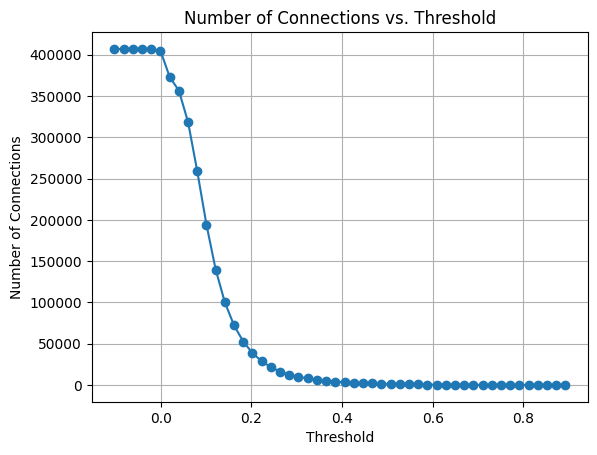

In [101]:
test=np.nan_to_num(data.mean(axis=2), nan=0)

# Listes pour stocker les valeurs de seuil et le nombre de connexions
thresholds = []
num_connections_list = []
num_connections_list_ind = []

min_threshold = np.min(test)
max_threshold = np.max(test)

for threshold in np.linspace(min_threshold, max_threshold, num=50):
    # Apply threshold to data
    thresholded_data = test >= threshold
    
    # Count number of remaining connections
    num_connections = np.sum(thresholded_data)
        
    # Enregistrer les valeurs de seuil et le nombre de connexions
    thresholds.append(threshold)
    num_connections_list.append(num_connections)
    
    # Print the threshold and number of connections
    print(f"Threshold: {threshold}, Number of Connections: {num_connections}")

# Tracer les valeurs
plt.plot(thresholds, num_connections_list, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Number of Connections')
plt.title('Number of Connections vs. Threshold')
plt.grid(True)
plt.show()


In [197]:
def get_nbConnection(matrice):
    num_connections_list = []
    for threshold in np.linspace(0.2,0.6,num=9):
        # Apply threshold to data
        thresholded_data = matrice >= threshold
        # Count number of remaining connections
        num_connections = np.sum(thresholded_data)
        # Enregistrer les valeurs de seuil et le nombre de connexions
        num_connections_list.append(num_connections)
    return(num_connections_list)

In [204]:
"580620CG" in subject_data_M36

True

In [219]:
del full_func_df

In [236]:
name_col = ['GROUP']
for cpt in np.linspace(0.2,0.6,num=9):
    name_col.append("nb_conn_"+str(np.round(cpt,2)))

full_func_df_M6 = pd.DataFrame(columns=name_col)
#Attention, & est différent de and... & c'est l'ensemble des clés communes
for ind in (set(subject_data_M6.keys()) & set(subject_data_M36.keys())):
    full_func_df_M6.loc[ind]=["M6"]+get_nbConnection(subject_data_M6[ind])
    
full_func_df_M36 = pd.DataFrame(columns=name_col)
for ind in (set(subject_data_M6.keys()) & set(subject_data_M36.keys())):
    full_func_df_M36.loc[ind]=["M36"]+get_nbConnection(subject_data_M36[ind])

full_func_df_combined = pd.concat([full_func_df_M6, full_func_df_M36], axis=0)
del full_func_df_M36; del full_func_df_M6


full_func_df_combined = full_func_df_combined.rename_axis("SUBJ")
full_func_df_combined.to_csv(os.path.join(STUDY_PATH,"functionnalConnectivity.csv"), index=True)


               T  dof alternative     p-val                 CI95%   cohen-d  \
T-test  0.904058   75   two-sided  0.368859  [-8305.65, 22108.02]  0.108993   

         BF10     power  
T-test  0.187  0.155289  


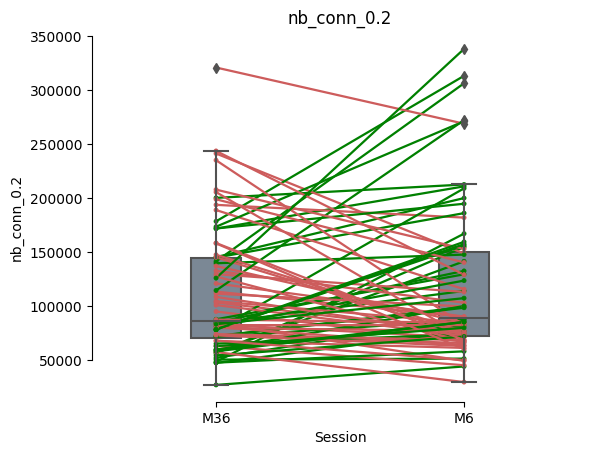

In [253]:
# Inverser l'ordre des niveaux de la variable GROUP
full_func_df_combined['GROUP'] = pd.Categorical(full_func_df_combined['GROUP'], categories=['M6', 'M36'], ordered=True)

for col in name_col[1:2]:
    print(pg.ttest(full_func_df_combined[full_func_df_combined["GROUP"]=="M6"][col].values,full_func_df_combined[full_func_df_combined["GROUP"]=="M36"][col].values,paired=True))
    plt.figure()
    ax = pg.plot_paired(data=full_func_df_combined, dv=col, within='GROUP', subject='SUBJ')
    plt.title(col)
    plt.xlabel("Session")
    ax.figure.savefig(os.path.join(STUDY_PATH,"M6_M36_comparison_Threshold0.2.png"))

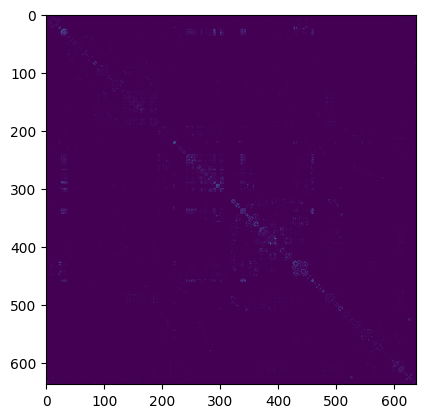

In [109]:
thresholded_data = data >= threshold
    
num_connections = np.sum(thresholded_data,axis=2)
plt.imshow(num_connections)

#plt.imshow(thresholded_data[:,:,5])

### Exemples de calcul de coeff degree betweenness closeness clustering etc ...avec networkx

In [42]:
import networkx as nx
import numpy as np

connectivity_matrix=mat_contents['zMat']
np.fill_diagonal(connectivity_matrix, 0)  # Remplir la diagonale de zéros

# Créer un graphe à partir de la matrice de connectivité
#G = nx.from_numpy_matrix(connectivity_matrix)
G = nx.from_numpy_array(connectivity_matrix)

# Calculer les métriques
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
clustering_coefficient = nx.clustering(G)
average_path_length = nx.average_shortest_path_length(G)
modularity = nx.algorithms.community.modularity(G, nx.algorithms.community.greedy_modularity_communities(G))

# Afficher les résultats
print("Degree Centrality:", degree_centrality)
print("Betweenness Centrality:", betweenness_centrality)
print("Closeness Centrality:", closeness_centrality)
print("Clustering Coefficient:", clustering_coefficient)
print("Average Path Length:", average_path_length)
print("Modularity:", modularity)

Degree Centrality: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 23: 1.0, 24: 1.0, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, 30: 1.0, 31: 1.0, 32: 1.0, 33: 1.0, 34: 1.0, 35: 1.0, 36: 1.0, 37: 1.0, 38: 1.0, 39: 1.0, 40: 1.0, 41: 1.0, 42: 1.0, 43: 1.0, 44: 1.0, 45: 1.0, 46: 1.0, 47: 1.0, 48: 1.0, 49: 1.0, 50: 1.0, 51: 1.0, 52: 1.0, 53: 1.0, 54: 1.0, 55: 1.0, 56: 1.0, 57: 1.0, 58: 1.0, 59: 1.0, 60: 1.0, 61: 1.0, 62: 1.0, 63: 1.0, 64: 1.0, 65: 1.0, 66: 1.0, 67: 1.0, 68: 1.0, 69: 1.0, 70: 1.0, 71: 1.0, 72: 1.0, 73: 1.0, 74: 1.0, 75: 1.0, 76: 1.0, 77: 1.0, 78: 1.0, 79: 1.0, 80: 1.0, 81: 1.0, 82: 1.0, 83: 1.0, 84: 1.0, 85: 1.0, 86: 1.0, 87: 1.0, 88: 1.0, 89: 1.0, 90: 1.0, 91: 1.0, 92: 1.0, 93: 1.0, 94: 1.0, 95: 1.0, 96: 1.0, 97: 1.0, 98: 1.0, 99: 1.0, 100: 1.0, 101: 1.0, 102: 1.0, 103: 1.0, 104: 1.0, 105: 1.0, 106: 1.0, 107: 1.0, 108: 1.0, 